In [29]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from fxpmath import Fxp

try:
    import mpld3
    mpld3.enable_notebook()
except:
    print("Modul mpld3 is NOT installed.")

def plot_signal(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots signal in Time domain. """
    plt.plot(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_spectrum(x, x_label = "", y_label = "", title = "", dB = True, show = True):
    """ Function that plots signal in Frequency domain. """
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    if dB:
        X = 20 * np.log10(X)
        X -= np.max(X)
    plt.plot(F, X)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_sonar(x, fs, c, slope, title="", show=True, **kwargs):
    n = len(x)
    F = np.fft.fftfreq(n)
    dist = F * fs * c / 2 / slope
    dist = dist[:n//2]
    X = abs(np.fft.fft(x))[:n//2]
    X_dB = 20 * np.log10(X)
    X_dB -= np.max(X_dB)
    # Threshold value
    th = -10
    # Find peaks above the threshold
    peaks, _ = signal.find_peaks(X_dB, height=th)
    # Convert indices to distances 
    distance_peaks = np.array(peaks) / n * fs * c / 2 / slope

    # fig = plt.figure(figsize=(6, 4))
    plt.plot(dist, X_dB)
    plt.plot(distance_peaks, X_dB[peaks], "x")
    # Annotate each peak with its distance
    for i, peak in enumerate(distance_peaks):
        plt.annotate(f'{peak:.2f} m', (peak + 0.3, X_dB[peaks][i]))
    plt.xlabel("Distance [m]")
    plt.ylabel("|X| dB")
    # plt.title(title if title else f"Spectrum of TX and RX channel product, fs = {round(fs / D / 1e3)} kHz")
    plt.title(title)
    plt.ylim([min(X_dB), 10])
    
    if show:
        plt.show()

def plot_FIR(fir_coeff, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots FIR impulse response in dB. """
    w, h = signal.freqz(fir_coeff)
    H = 20 * np.log10(abs(h))
    plt.plot(w / (2 * np.pi), H)
    plt.plot([1 / (2 * D) - transition_width, 1 / (2 * D) - transition_width], [np.min(H), 0], "r--")
    plt.plot([1 / (2 * D), 1 / (2 * D)], [np.min(H), 0], "r--");
    plt.plot([1 / (2 * D) + transition_width, 1 / (2 * D) + transition_width], [np.min(H), 0], "r--")
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def stem_FIR(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that stems FIR's coeffitients. """
    plt.stem(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def gen_FIR(n_FIR, D, transition_width):
    """ Function that generates FIR coeffitients based on number of coeffitients and transititon zone. """
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    fir_coeff = signal.firls(n_FIR, fir_freqs, fir_response, fs = 1)
    return fir_coeff

def gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True):
    """ Function that generates FIR coeffitients based on ripple in pass band and attenuation in non-passed band. """
    num_taps = n_FIR
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    if not symetric:
        fir_freqs[2] = 1 / (2 * D)
        
    while(True):
        fir_coeff = signal.firls(num_taps, fir_freqs, fir_response, fs = 1)
        w, h = signal.freqz(fir_coeff)
        H = 20 * np.log10(abs(h))
        ripple_ = np.max(H[:int(len(H) * 2*fir_freqs[1])]) - np.min(H[:int(len(H) * 2*fir_freqs[1])])
        attenuation_ = np.max(H[int(len(H) * 2*fir_freqs[2]):])
        if(ripple_ <= ripple and -attenuation_ >= attenuation):
            break
        else:
            num_taps += 2
    return fir_coeff

def gen_test_spectrum(n, freq, amp, rand_phase = False):
    ''' Generate test spectrum
         Arguments:
            n    - number of samples
            freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
            amp  - tuple of amplitudes (ampStart, ampEnd)
            randPhase - if True, assign random phase to each sample '''
    freq_start, freq_end = freq
    amp_start, amp_end = amp
    ind_start = round(n * freq_start)
    ind_end = round(n * freq_end)
    x = np.zeros(n, dtype = "complex128")
    x[ind_start : ind_end] = amp_start - np.linspace(0, 1, num = ind_end - ind_start) * (amp_start - amp_end)
    if rand_phase:
        x[ind_start : ind_end] *= np.exp(1j * 2 * np.pi * np.random.rand(ind_end - ind_start))
    x[0] = abs(x[1]) / 2

    x_time_domain = np.fft.ifft(x)
    return x_time_domain


In [149]:
def fir_direct_fxp(x, h, state = None, outFxpFormat = None):
    M = len(h)
    if state == None:
        delayLine = Fxp(np.zeros(M), like = x) # like = x, kaze da je format delayLine-a isti kao i format x-a
    else:
        delayLine = state
    
    if outFxpFormat == None:
        y = Fxp(np.zeros(len(x)), signed = True, n_word = x.n_word + h.n_word + int(np.ceil(np.log2(M))), n_frac = x.n_frac + h.n_frac)
    else:
        y = Fxp(np.zeros(len(x)), dtype = outFxpFormat)
    
    y.overflow = x.overflow
    y.rounding = x.rounding
    
    for n in range(len(x)):
        delayLine[1:] = delayLine[:M-1]
        delayLine[0] = x[n]
        sumVal = Fxp(0, like = delayLine[0]*h[0])
        for m in range(M):
            sumVal += h[m]*delayLine[m]
        y[n] = Fxp(sumVal, like = y)
    
    return y



In [150]:
n = 128
overFlowMethod = 'saturate'
roundingMethod = 'trunc'
n_word = 16
n_frac = 15
D = 2

tst = Fxp(None, signed = True, n_word = n_word, n_frac = n_frac, overflow = overFlowMethod, rounding = roundingMethod)

F1 = 0.1
F2 = 0.43

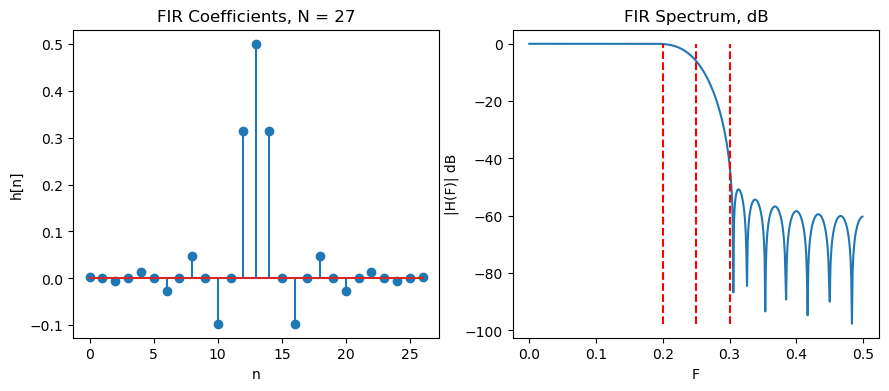

In [151]:
n_FIR = 1
ripple = 1e-1
attenuation = 40 # in dB
transition_width = 0.05
fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)
h_Fxp = Fxp(fir_coeff, like = tst)
h_Fxp.overflow, h_Fxp.rounding = tst.overflow, tst.rounding

figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(fir_coeff, 'n', 'h[n]', f"FIR Coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(fir_coeff, 'F', '|H(F)| dB', "FIR Spectrum, dB", show = False)

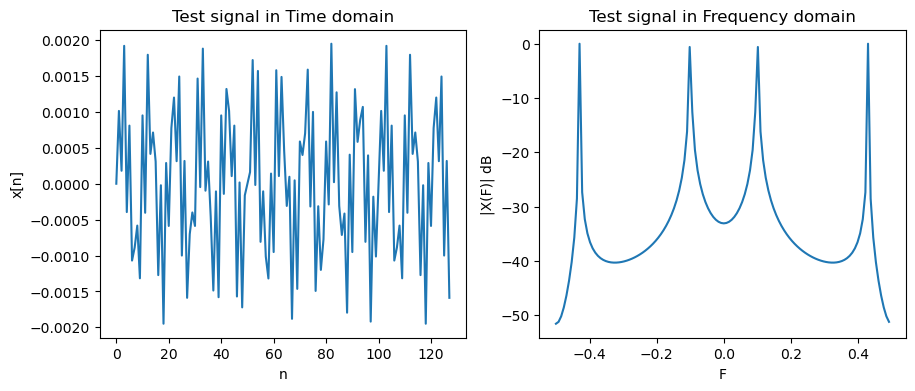

In [152]:
x = 1e-3 * (np.sin(2*np.pi*F1*np.arange(n)) + np.sin(2*np.pi*F2*np.arange(n)))
x_per = np.concatenate((x, x[:len(fir_coeff)]))
x_per_Fxp = Fxp(x_per, like = tst)
x_per_Fxp.overflow, x_per_Fxp.rounding = tst.overflow, tst.rounding

# Plot results
figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_signal(x, 'n', 'x[n]', "Test signal in Time domain", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_spectrum(x, 'F', '|X(F)| dB', "Test signal in Frequency domain", show = False)

In [153]:
y = fir_direct_fxp(x_per_Fxp, h_Fxp)

In [154]:
print(y.info)
print(len(y))

<bound method Fxp.info of fxp-s37/30([ 0.00000000e+00  2.39722431e-06  3.63215804e-07 -2.04239041e-06
            -1.86357647e-06  3.60421836e-06  1.96136534e-06 -7.64150172e-06
            -3.58000398e-06  1.26054510e-05  8.31019133e-06 -3.07420269e-05
            -1.42715871e-05  1.81963667e-04  5.53584658e-04  8.97193328e-04
             9.45612788e-04  6.01124950e-04 -1.31409615e-06 -5.94739802e-04
            -9.48749483e-04 -9.43519175e-04 -5.83191402e-04 -1.16135925e-06
             5.82812354e-04  9.36858356e-04  9.29838978e-04  5.70954755e-04
             5.68106771e-07 -5.66928647e-04 -9.25694592e-04 -9.33981501e-04
            -5.86099923e-04 -3.22703272e-06  5.80810010e-04  9.37926583e-04
             9.35613178e-04  5.77662140e-04  1.09709799e-06 -5.86546957e-04
            -9.49997455e-04 -9.48674977e-04 -5.83937392e-04 -1.21537596e-06
             5.78262843e-04  9.43730585e-04  9.45874490e-04  5.84874302e-04
            -2.10758299e-06 -5.80169261e-04 -9.31324437e-04 -9

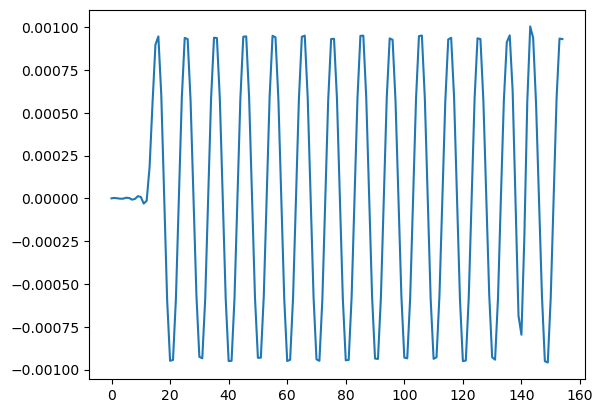

In [155]:
plt.plot(y)

In [97]:
0.00100708 * 2**15

32.99999744